# Attempting to Classify Hypoxia Induced Slurring in Pilot's Speech using Convolutional Neural Networks
## Speech and Audio Processing Final Project
### Mark Doyle - 21385593

<img src="./images/a350_cockpit.jpg" style="max-height: 500px;"/>

## Cabin Pressure

Commercial aircraft cabins are pressurised to allow passengers to breathe comfortably at high altitudes.

They have systems to monitor the cabin pressure and the oxygen levels in the cabin. You've probably heard before during a Safety Briefing that "*in the event of a cabin depressurisation, oxygen masks will automatically drop down from the ceiling*".

In smaller aircraft and particularly military aircraft, the warning systems are not as sophisticated and the pilots are responsible for monitoring the cabin pressure and the oxygen levels.

Although pilots are trained to recognise the symptoms of hypoxia, it is not always obvious to them.

Hypoxia occurs when the body doesn't get enough oxygen.

<img src="./images/cabin_altitude.png" style="max-height: 500px;"/>

The slurring of speech is a common symptom of hypoxia. **Medically it is known as dysarthria**. Often during a hypoxia incident, air traffic controllers will slowly begin to notice the pilot's speech becoming more slurred and will eventually ask if they are ok.

In this project I'm using a Convolutional Neural Network to classify speech as either dysarthric or non-dysarthric. This could be potentially used by air traffic controllers to detect hypoxia before it becomes too severe.

## Using the [TORGO](https://www.cs.toronto.edu/~complingweb/data/TORGO/torgo.html) Dataset
<img src="./images/torgo.png" style="max-height: 500px;"/>

In [3]:
import pandas as pd
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import noisereduce as nr
import numpy as np
import seaborn as sns
import warnings

In [4]:
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

In [20]:
data = pd.read_csv("./torgo_data/data.csv")
data['is_dysarthria'] = data['is_dysarthria'].map({'dysarthria': True, 'non_dysarthria': False})
data.sort_values(by='is_dysarthria', inplace=True)

In [70]:
# Creating some basic samples
data.sample(frac=1).reset_index(drop=True,inplace=True)

male_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria'])].sample(1)
female_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria'])].sample(1)
male_not_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria']==False)].sample(1)
female_not_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria']==False)].sample(1)

male_dysarthric = data[data['filename'].str.contains('M01_Session2_3_0049.wav')]
male_not_dysarthric = data[data['filename'].str.contains('MC01_Session3_0053.wav')]

## Resolving Issues with the Poor Quality Audio in the Dataset

The vast majority of the wav files have some kind of buzzing noise in the background. Lets see what we can do about it.

Taking a sample from the female non-dysarthric class, we can hear a lot of noise in the audio.







In [71]:
ipd.Audio(male_not_dysarthric.iloc[0].filename)

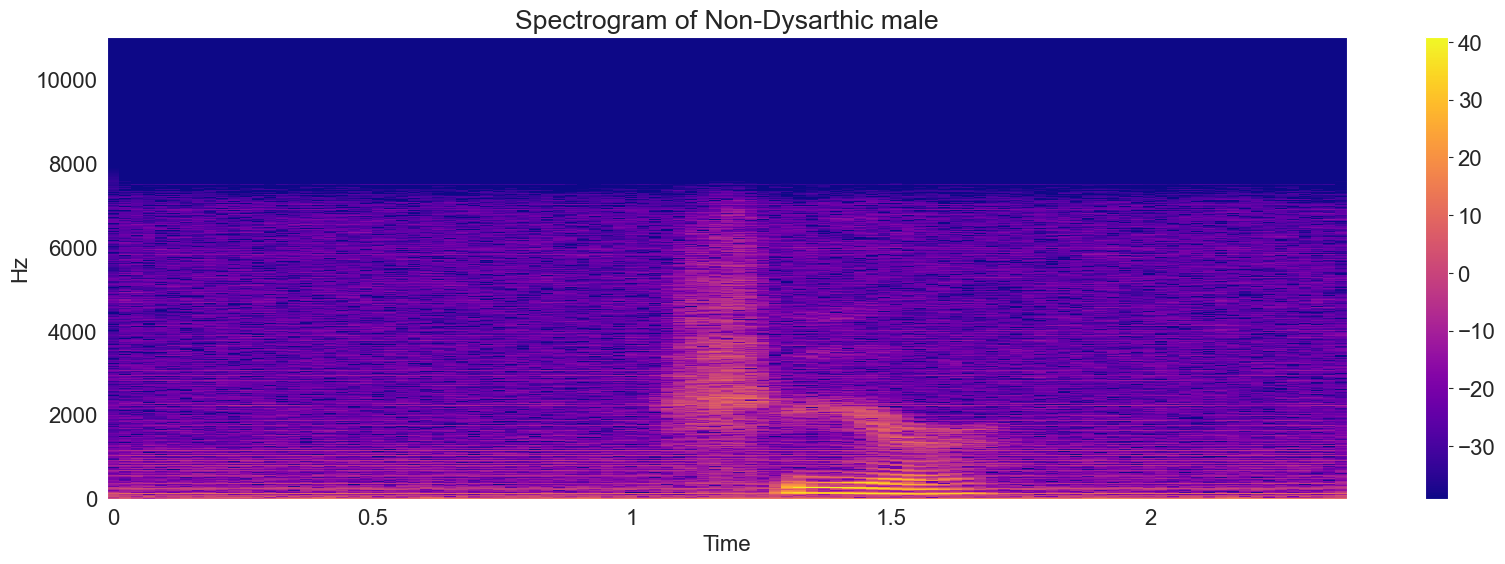

In [90]:
def label(type, row):
    return f"{type} of {"Dysarthic" if row['is_dysarthria'] else "Non-Dysarthic"} {row['gender']}"

def show_spectrogram(y, sr, label):
    X = librosa.stft(y)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(20,6))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='plasma')
    plt.colorbar()
    plt.title(label)

y, sr = librosa.load(male_not_dysarthric.iloc[0].filename)
show_spectrogram(y, sr, label("Spectrogram", male_not_dysarthric.iloc[0]))

In the above spectogram the buzzing appears alongside the speech as a strong band in the lower frequencies (below 2000 Hz).

**Lets remove this noise using Spectral Gating**

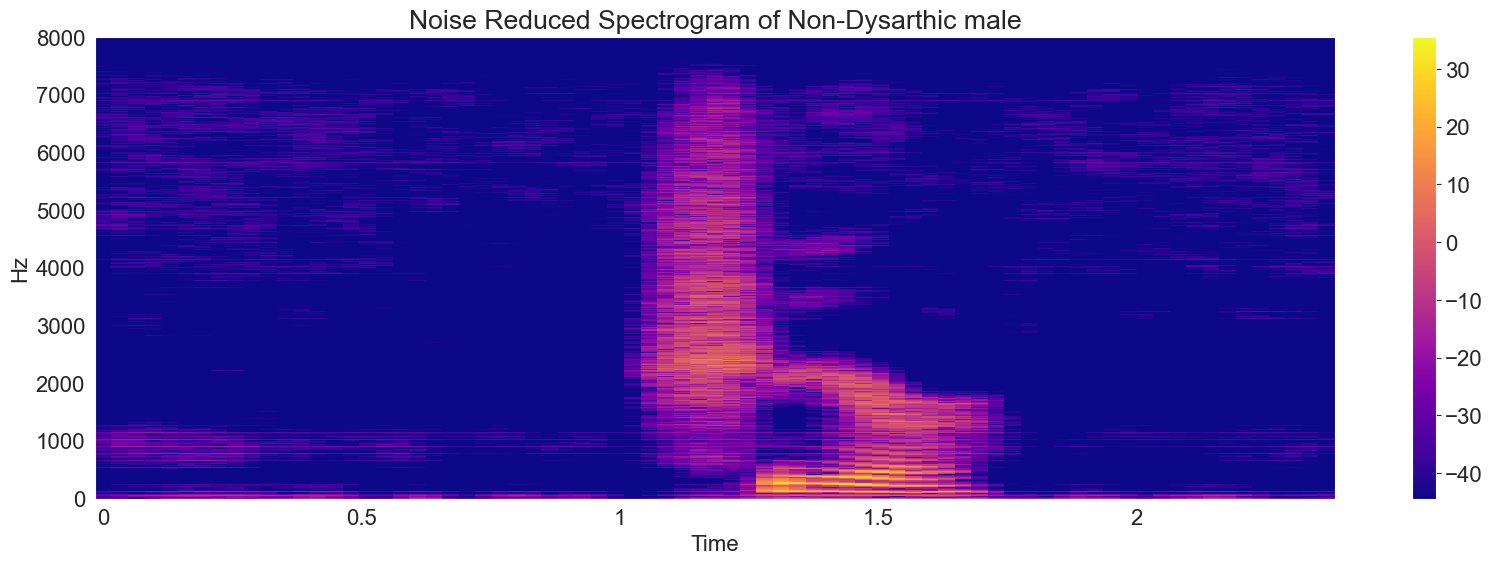

In [405]:
def preprocess_row_audio(row):
    y, sr = librosa.load(row['filename'], sr=None)

    noise_clip = y[0:int(sr)]
    reduced = nr.reduce_noise(
        y=y, 
        sr=sr,
        y_noise=noise_clip,
        prop_decrease=1,
        freq_mask_smooth_hz=500,
        n_std_thresh_stationary=1.5
    )

    return reduced, sr, row

y, sr, row = preprocess_row_audio(male_not_dysarthric.iloc[0])
show_spectrogram(y, sr, label("Noise Reduced Spectrogram", row))

In [406]:
ipd.Audio(y, rate=sr)

We can observe from the spectogram and by listening to the audio that the noise has been significantly reduced. Success!

We'll apply this processing to all audio prior to training our model.

## Can we use the spectrogram to train our model?

### Comparing the Spectograms of Dysarthric and Non-Dysarthric Speech

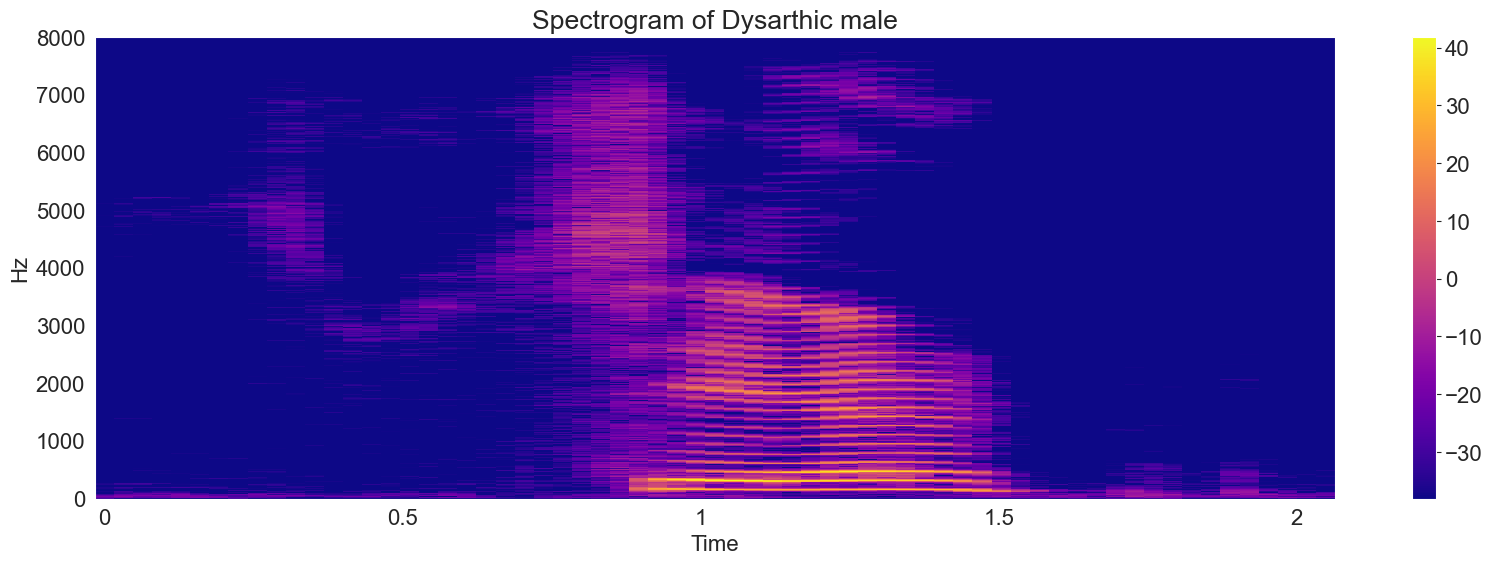

In [76]:
preprocessed_male_dysarthric, sr_m_d, row_m_d = preprocess_row_audio(male_dysarthric.iloc[0])
show_spectrogram(preprocessed_male_dysarthric, sr_m_d, label("Spectrogram", row_m_d))

In [112]:
ipd.Audio(preprocessed_male_dysarthric, rate=sr_m_d)

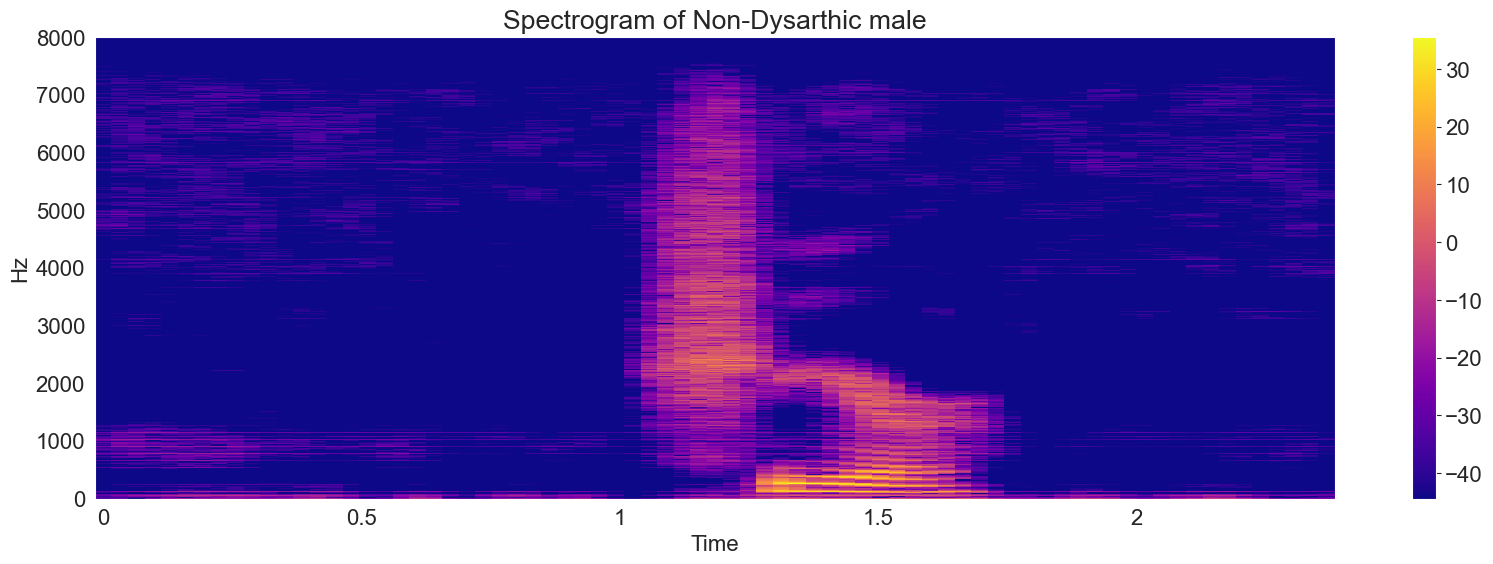

In [110]:
preprocessed_male_non_dysarthric, sr_m, row_m = preprocess_row_audio(male_not_dysarthric.iloc[0])
show_spectrogram(preprocessed_male_non_dysarthric, sr_m, label("Spectrogram", row_m))

In [111]:
ipd.Audio(preprocessed_male_non_dysarthric, rate=sr_m)

Non-dysarthric spectrograms typically show clear, well-defined formant bands (dark horizontal stripes) with sharp transitions between phonemes, while dysarthric spectrograms often display more blurred or irregular formant patterns, reduced frequency range, and less distinct transitions between sounds - reflecting the impaired muscle control and reduced precision in articulation characteristic of dysarthric speech.


# What other features can we use to train our model?

### Chroma Features

Chroma features represent the spectral energy distribution across the 12 pitch classes


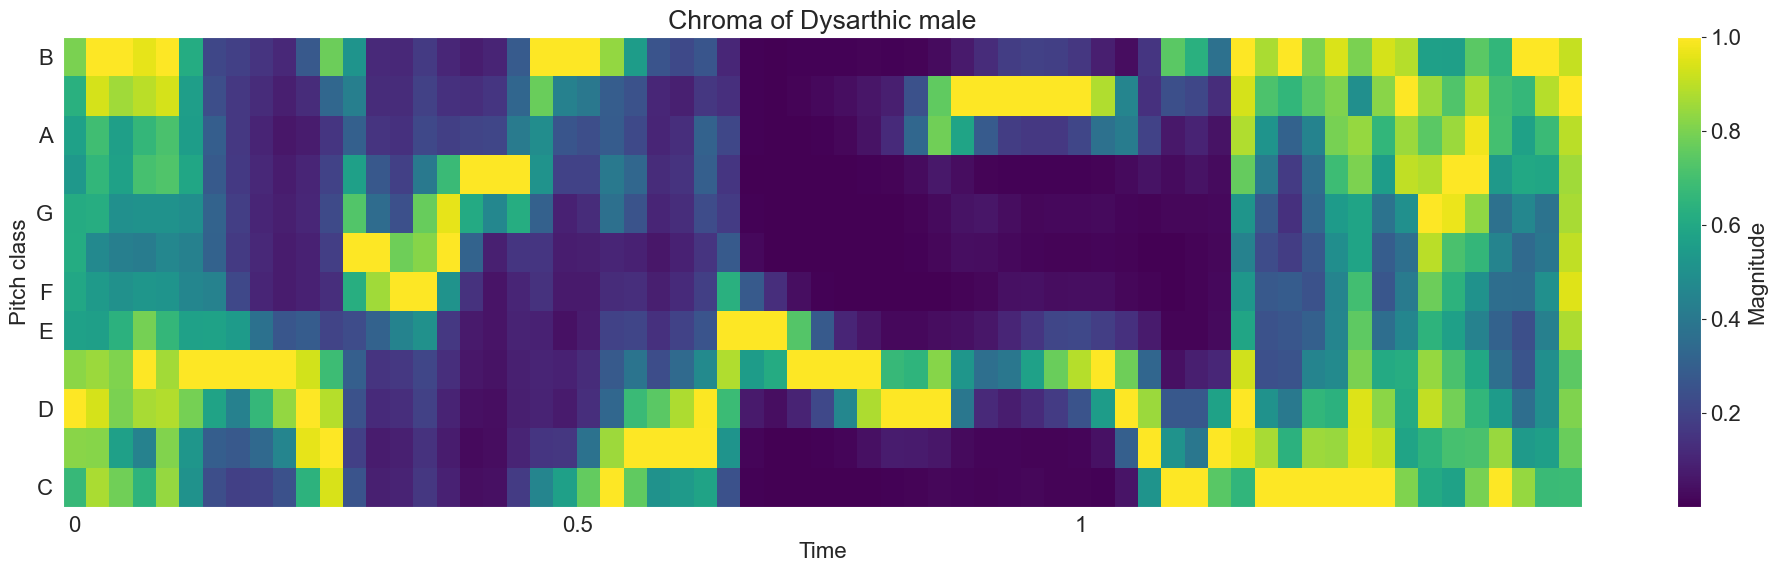

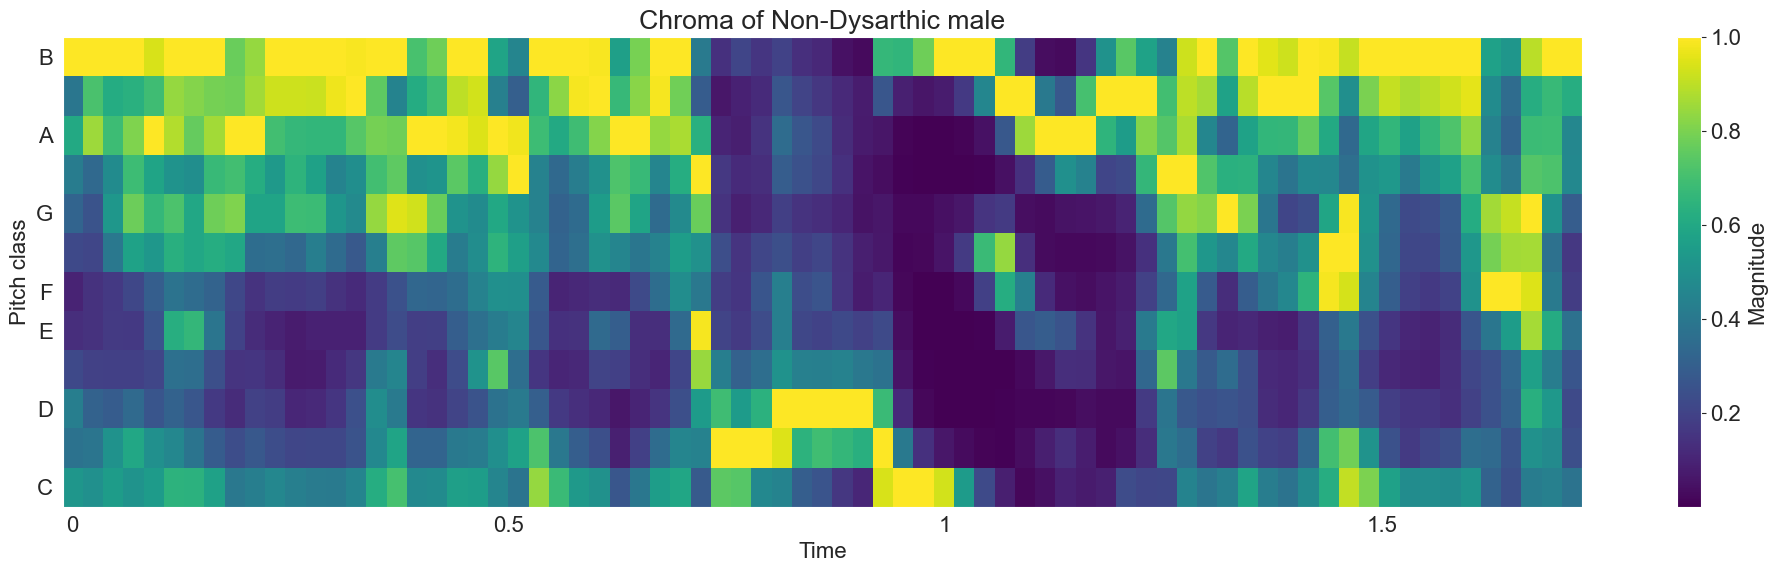

In [113]:
def show_chroma(y, sr, row):
    plt.figure(figsize=(20, 6))
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title(label("Chroma", row))
    plt.tight_layout()
    plt.show()

show_chroma(preprocessed_male_dysarthric, sr_m_d, row_m_d)
show_chroma(preprocessed_male_non_dysarthric, sr_m, row_m)

### Zero Crossing Rate
ZCR measures how often the audio signal crosses the zero amplitude line

Zero Crossing Rate (ZCR) counts how many times the audio wave crosses from positive to negative or vice versa - imagine a squiggly line going up and down around a center line, and we're counting each time it crosses that center line. Higher ZCR often means more noisy or unclear speech, while lower ZCR usually means clearer, more stable speech

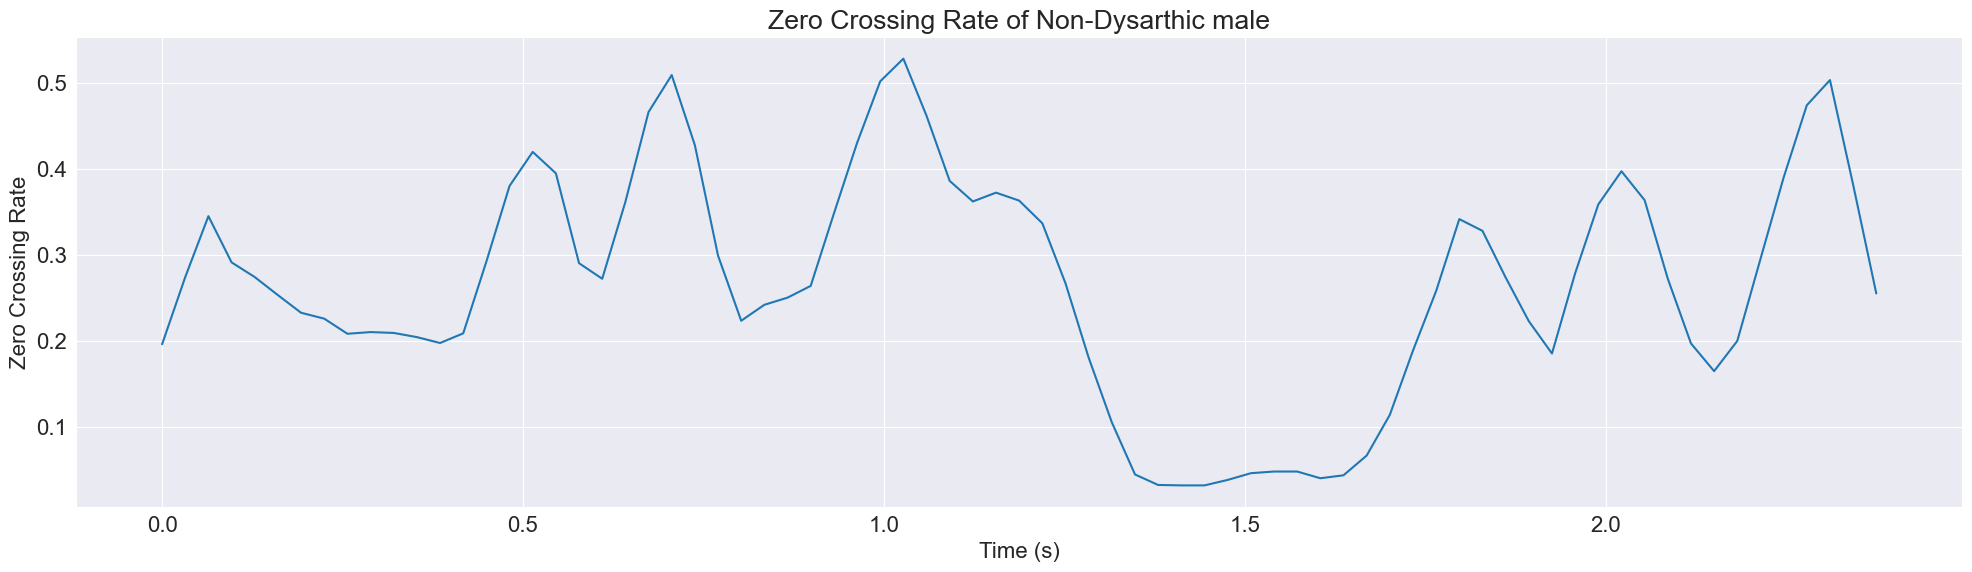

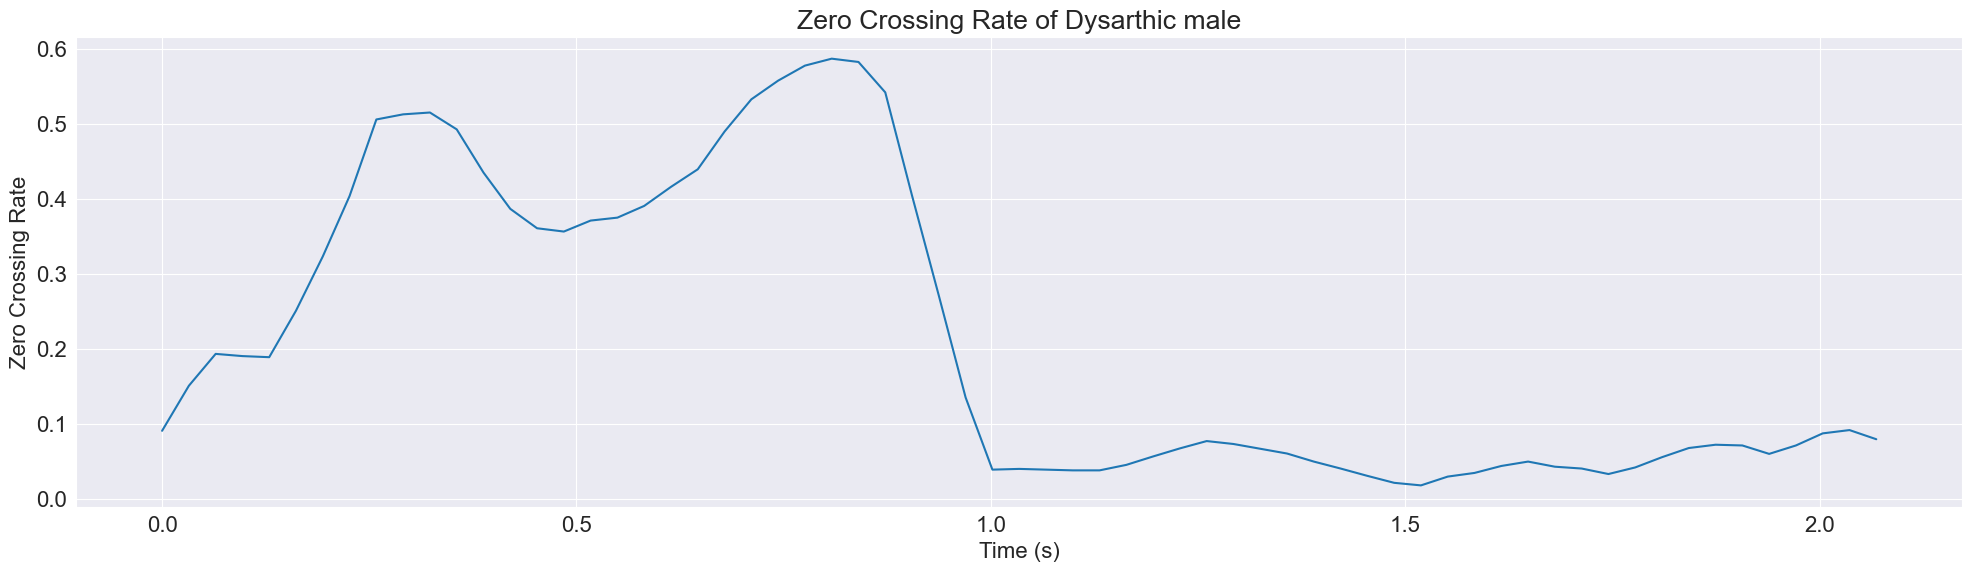

In [114]:
def show_zcr(y, sr, row):
    plt.figure(figsize=(20, 6))
    zcr = librosa.feature.zero_crossing_rate(y)
    plt.plot(np.linspace(0, len(y)/sr, len(zcr[0])), zcr[0])
    plt.xlabel('Time (s)')
    plt.ylabel('Zero Crossing Rate')
    plt.title(label("Zero Crossing Rate", row))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

show_zcr(preprocessed_male_non_dysarthric, sr_m, row_m)
show_zcr(preprocessed_male_dysarthric, sr_m_d, row_m_d)

### Root Mean Square Energy
RMS energy shows the amplitude envelope of the speech signal

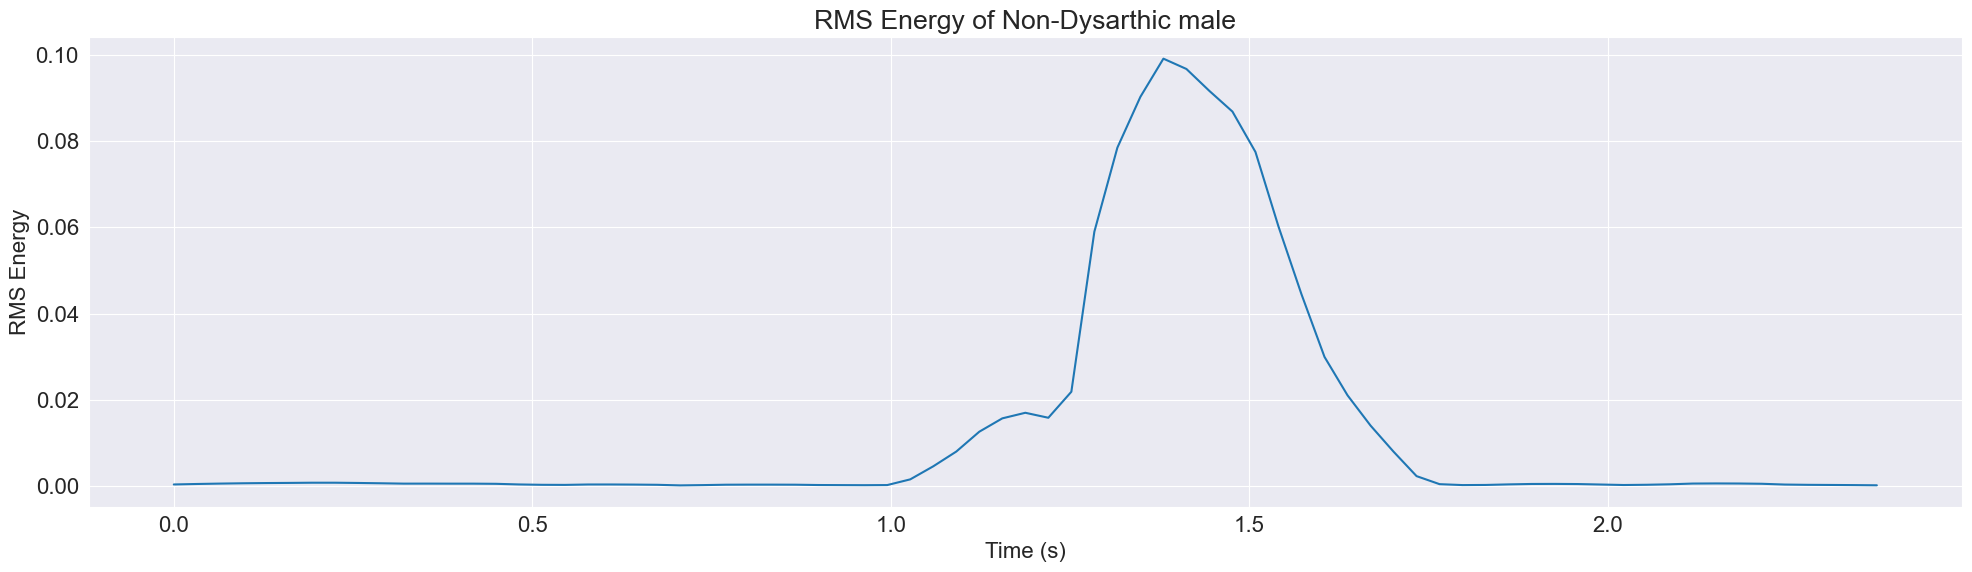

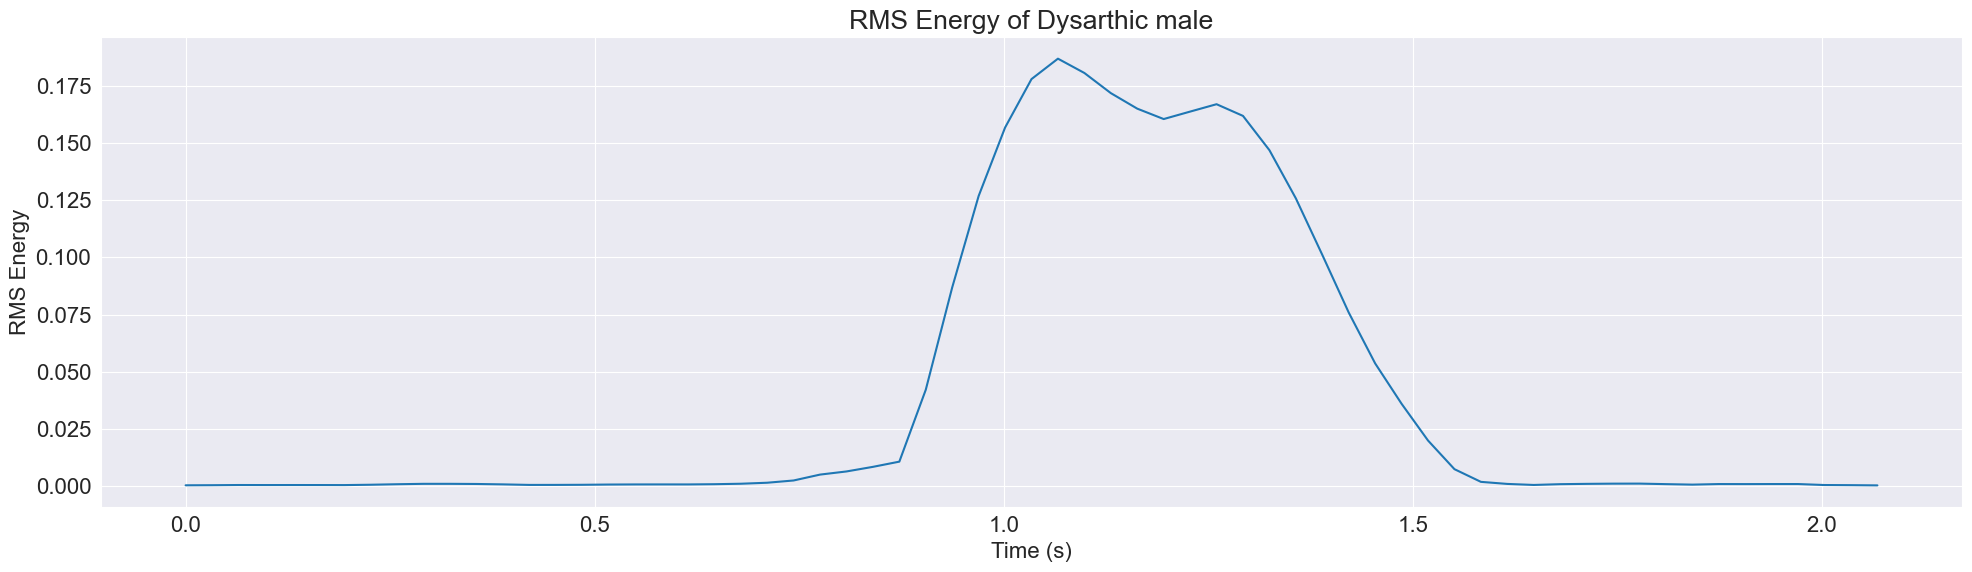

In [115]:
def show_rms(y, sr, row):
    plt.figure(figsize=(20, 6))
    rms = librosa.feature.rms(y=y)[0]
    plt.plot(np.linspace(0, len(y)/sr, len(rms)), rms)
    plt.xlabel('Time (s)')
    plt.ylabel('RMS Energy')
    plt.title(label("RMS Energy", row))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

show_rms(preprocessed_male_non_dysarthric, sr_m, row_m)
show_rms(preprocessed_male_dysarthric, sr_m_d, row_m_d)

### Mel Spectrogram

The mel spectrogram is similar to the spectrogram, but it is more sensitive to the human ear.

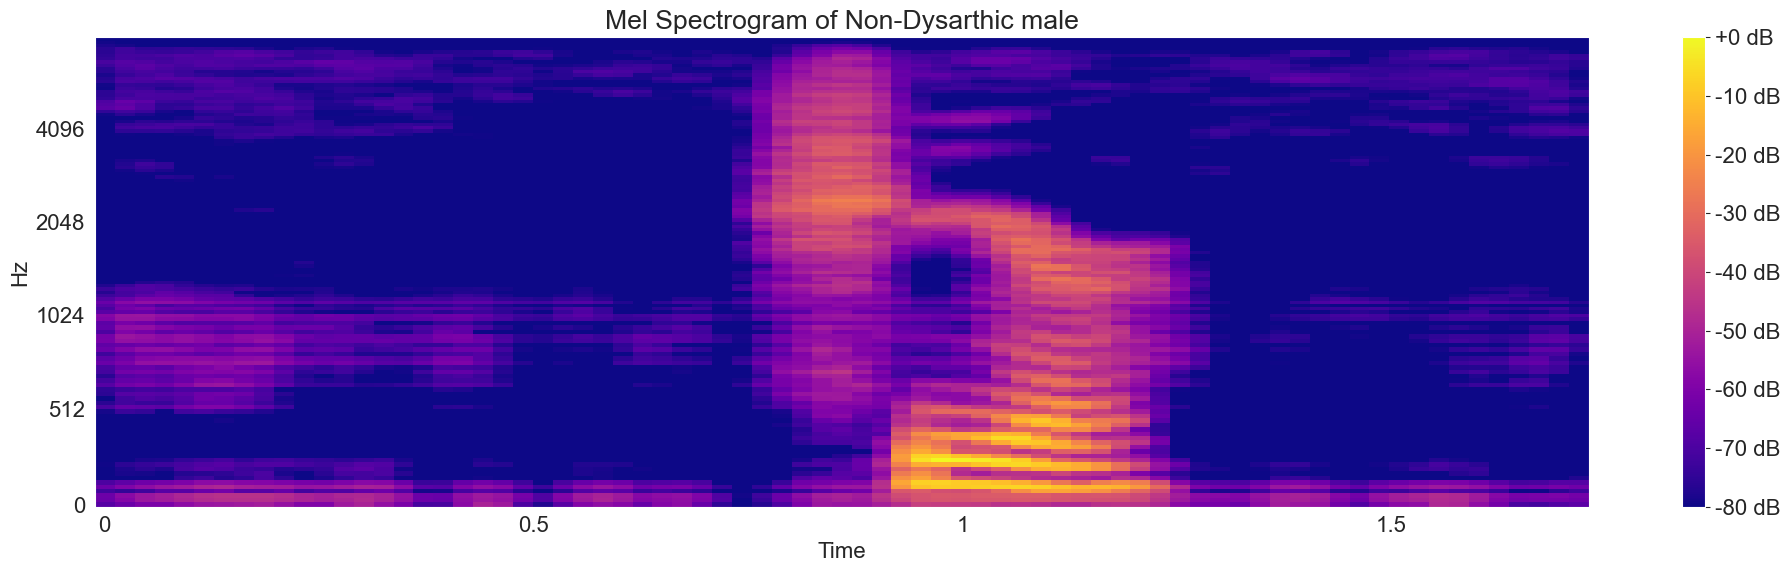

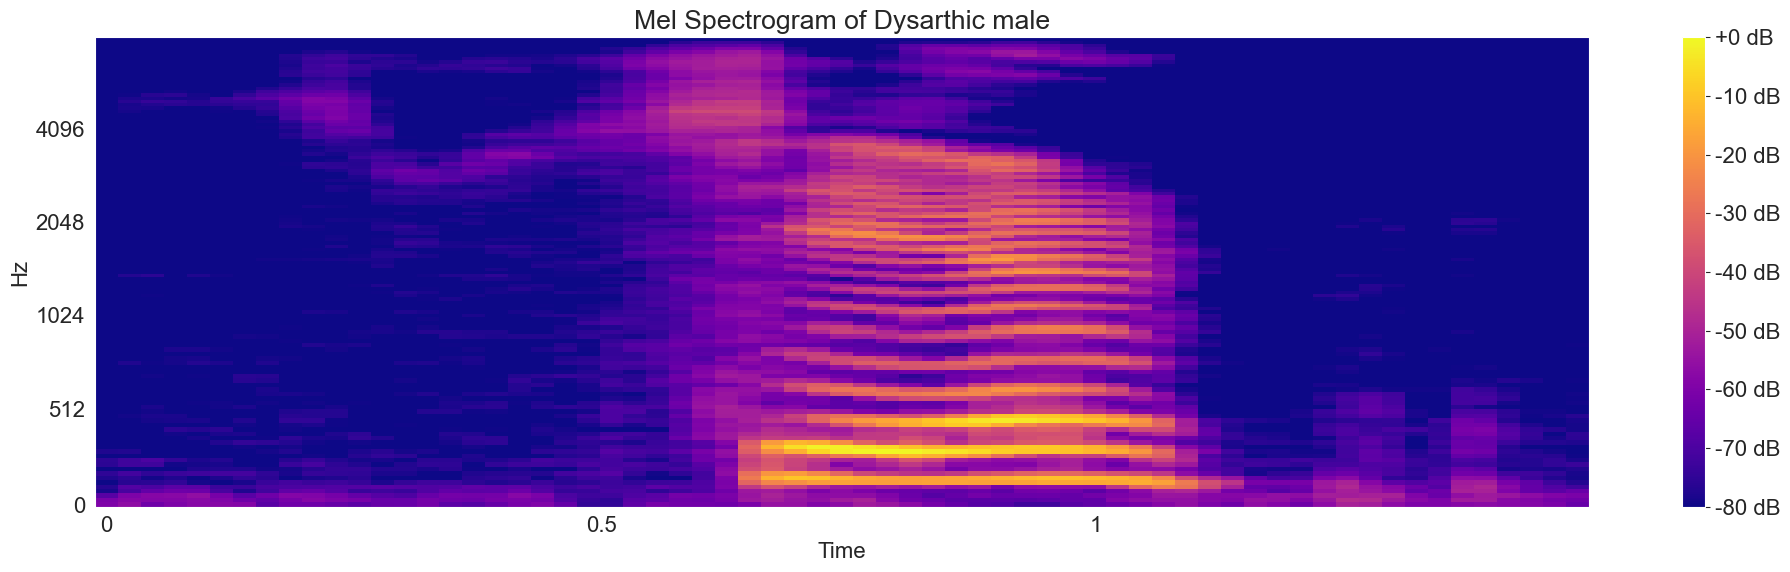

In [150]:
def show_mel_spectrogram(y, sr, row):
    plt.figure(figsize=(20, 6))
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), x_axis='time', y_axis='mel', fmax=8000, cmap='plasma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(label("Mel Spectrogram", row))
    plt.tight_layout()
    plt.show()

show_mel_spectrogram(preprocessed_male_non_dysarthric, sr_m, row_m)
show_mel_spectrogram(preprocessed_male_dysarthric, sr_m_d, row_m_d)


## Model Training

In [85]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [130]:
def preprocess_row_audio(row):
    y, sr = librosa.load(row['filename'], sr=None)

    noise_clip = y[0:int(sr)]
    reduced = nr.reduce_noise(
        y=y, 
        sr=sr,
        y_noise=noise_clip,
        prop_decrease=0.8,
        freq_mask_smooth_hz=200,
        n_std_thresh_stationary=1.5
    )

    return reduced, sr, row

In [336]:
def extract_features(y, sr):        
        # MFCC features with deltas
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        
        if mfcc.shape[1] > 1:
            mfcc_delta = librosa.feature.delta(mfcc)
            mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        else:
            mfcc_delta = np.zeros_like(mfcc)
            mfcc_delta2 = np.zeros_like(mfcc)
        
        # Spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        
        # Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        
        # Zero crossing rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
        
        # RMS energy
        rms = librosa.feature.rms(y=y)
        
        # Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
        
        # Combine all features
        feature_vector = np.concatenate([
            np.mean(mfcc, axis=1),
            np.mean(mfcc_delta, axis=1),
            np.mean(mfcc_delta2, axis=1),
            np.mean(spectral_centroid, axis=1),
            np.mean(spectral_bandwidth, axis=1),
            np.mean(spectral_rolloff, axis=1),
            np.mean(chroma, axis=1),
            np.mean(zero_crossing_rate, axis=1),
            np.mean(rms, axis=1),
            np.mean(mel_spec, axis=1)
        ])
        
        return feature_vector

In [407]:
features = []
for _, row in tqdm(data.iterrows(), total=data.shape[0]):
    try:
        y, sr, _ = preprocess_row_audio(row)
        features.append(extract_features(y, sr))

    except Exception as e:
        print(f"Error processing row: {e}")
        continue

 69%|██████▉   | 1388/2000 [01:18<00:46, 13.21it/s]

Error processing row: when mode='interp', width=9 cannot exceed data.shape[axis]=2


 85%|████████▍ | 1699/2000 [01:36<00:12, 23.74it/s]

Error processing row: 


100%|██████████| 2000/2000 [01:52<00:00, 17.82it/s]


In [223]:
features = pd.DataFrame(features)
features['class'] = data['is_dysarthria']
features

0          1          2          3         4          5  \
0    -317.713287  70.472618   5.604749  19.391075  0.809667   9.618432   
1    -305.558258  51.733700   7.207030  26.901384  0.491368   8.008273   
2    -352.376221  78.537804  23.514696  21.093983  7.051458  13.901584   
3    -387.458801  84.041199  18.113338  21.731262  3.543621   9.600302   
4    -374.044312  76.131660  22.812794  13.386932  2.071460  12.939844   
...          ...        ...        ...        ...       ...        ...   
1993 -466.184814  90.204071   9.544477  20.243864  3.671550  18.486683   
1994 -369.971497  60.887630  14.336483  15.308111  1.172256  11.773049   
1995 -513.667297  49.428242  18.196232  15.622179  9.208130  16.217537   
1996 -381.038574  59.001095  20.222136  17.327671  5.922287  14.603667   
1997 -471.680847  52.103767  27.534868  17.820623  4.718248  14.199100   

              6          7         8          9  ...       127       128  \
0     -2.122646   5.861811 -2.430908   1.836165  ...  0.160243  0.144934   
1      4.022964  10.929636  0.885788   2.343018  ...  0.214921  0.205930   
2      6.116352   5.695104  5.088280  -0.652862  ...  0.254240  0.172728   
3      7.955677   9.114902 -2.778860   1.111509  ...  0.200627  0.171719   
4     13.294973  15.697989  1.780792  10.446075  ...  0.140082  0.136060   
...         ...        ...       ...        ...  ...       ...       ...   
1993  12.023518  18.350954  3.141479  11.780379  ...  0.164054  0.168754   
1994   6.972700  10.709748  3.980232   5.582272  ...  0.153873  0.167756   
1995   2.963324   7.480606 -1.743183   9.552807  ...  0.257151  0.262623   
1996  11.342512  12.452869 -0.295669   9.097881  ...  0.200527  0.186832   
1997   8.749010   8.756317  1.944955   4.612024  ...  0.382628  0.374530   

           129       130       131       132       133       134       135  \
0     0.168153  0.226752  0.306425  0.309664  0.441508  0.658870  0.133434   
1     0.196756  0.274515  0.267176  0.369283  0.617246  0.702825  0.133687   
2     0.162911  0.284808  0.333012  0.367182  0.568591  0.695752  0.065494   
3     0.206902  0.227127  0.308844  0.394033  0.661748  0.766023  0.088768   
4     0.158960  0.228922  0.263459  0.331042  0.618470  0.903730  0.094480   
...        ...       ...       ...       ...       ...       ...       ...   
1993  0.175715  0.179830  0.300486  0.520097  0.806130  0.794828  0.054036   
1994  0.150904  0.149435  0.216432  0.316896  0.630410  0.862184  0.116992   
1995  0.328859  0.416746  0.464543  0.507809  0.643983  0.758415  0.143888   
1996  0.163473  0.209117  0.300949  0.400212  0.677698  0.884713  0.115395   
1997  0.360380  0.319825  0.308545  0.462671  0.697903  0.774503  0.089315   

      class  
0     False  
1     False  
2     False  
3     False  
4     False  
...     ...  
1993   True  
1994   True  
1995   True  
1996   True  
1997   True  

[1998 rows x 137 columns]

In [224]:
X = features.drop('class', axis=1)
y = features['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [225]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  confusion_matrix, roc_auc_score

In [226]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_features = X_train_scaled.shape[1]

n_rows = int(np.ceil(np.sqrt(n_features)))
n_cols = int(np.ceil(n_features / n_rows))

X_train_padded = np.zeros((X_train_scaled.shape[0], n_rows * n_cols))
X_test_padded = np.zeros((X_test_scaled.shape[0], n_rows * n_cols))
X_train_padded[:, :n_features] = X_train_scaled
X_test_padded[:, :n_features] = X_test_scaled

X_train_reshaped = X_train_padded.reshape(-1, n_rows, n_cols, 1)
X_test_reshaped = X_test_padded.reshape(-1, n_rows, n_cols, 1)

In [227]:
n_features = X_train_scaled.shape[1]
n_rows = int(np.ceil(np.sqrt(n_features)))
n_cols = int(np.ceil(n_features / n_rows))

In [307]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([
    Conv2D(32, (2, 2), activation='relu', padding='same', input_shape=(n_rows, n_cols, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,409 (177.38 KB)

 Trainable params: 45,409 (177.38 KB)

 Non-trainable params: 0 (0.00 B)

In [308]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [309]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [412]:
history = model.fit(X_train_reshaped, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test_reshaped, y_test),
                    callbacks=[checkpoint, earlystopping])

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
test_acc

Epoch 1/50
51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9948 - loss: 0.0149
Epoch 1: val_loss did not improve from 0.06568
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9949 - loss: 0.0148 - val_accuracy: 0.9700 - val_loss: 0.1111
Epoch 2/50
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0086
Epoch 2: val_loss did not improve from 0.06568
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9977 - loss: 0.0089 - val_accuracy: 0.9650 - val_loss: 0.1389
Epoch 3/50
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0058
Epoch 3: val_loss did not improve from 0.06568
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0059 - val_accuracy: 0.9600 - val_loss: 0.1338
Epoch 4/50
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0081
Epoch 4: val_loss did not improve from 0.06568
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9983 - loss: 0.0079 - val_accuracy: 0.9650 - val_loss: 0.1368
Epoch 5/50
46/57

0.9700000286102295

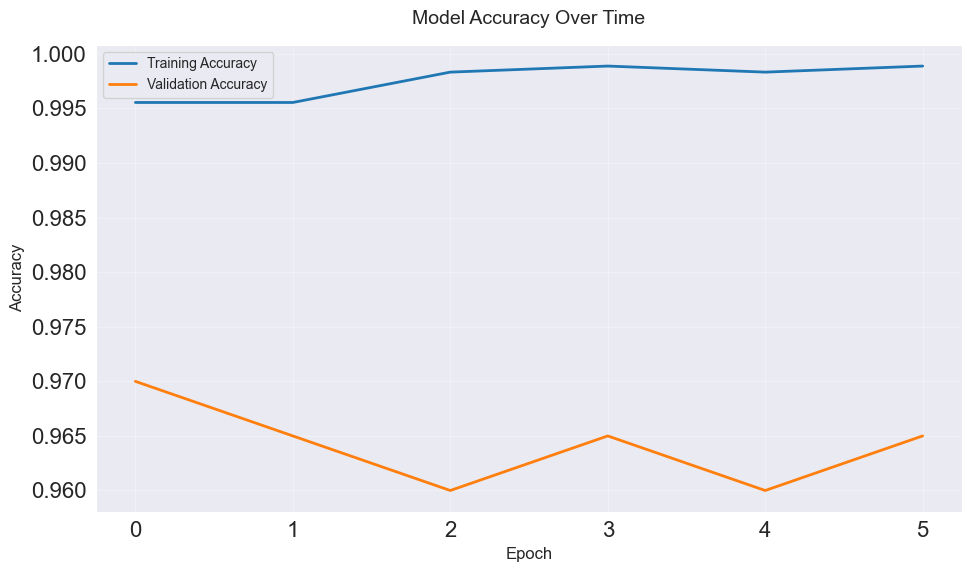

In [413]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy Over Time', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

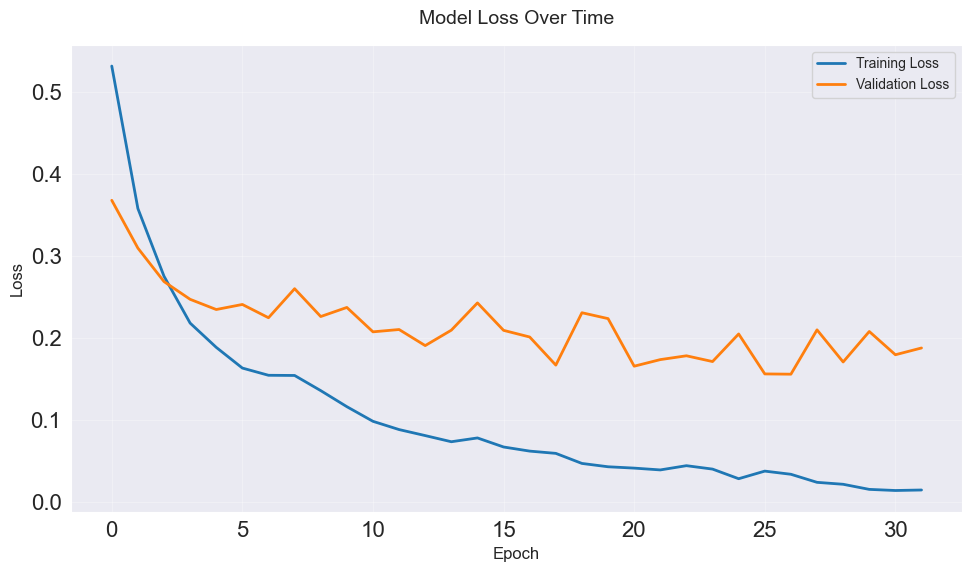

In [312]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Time', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

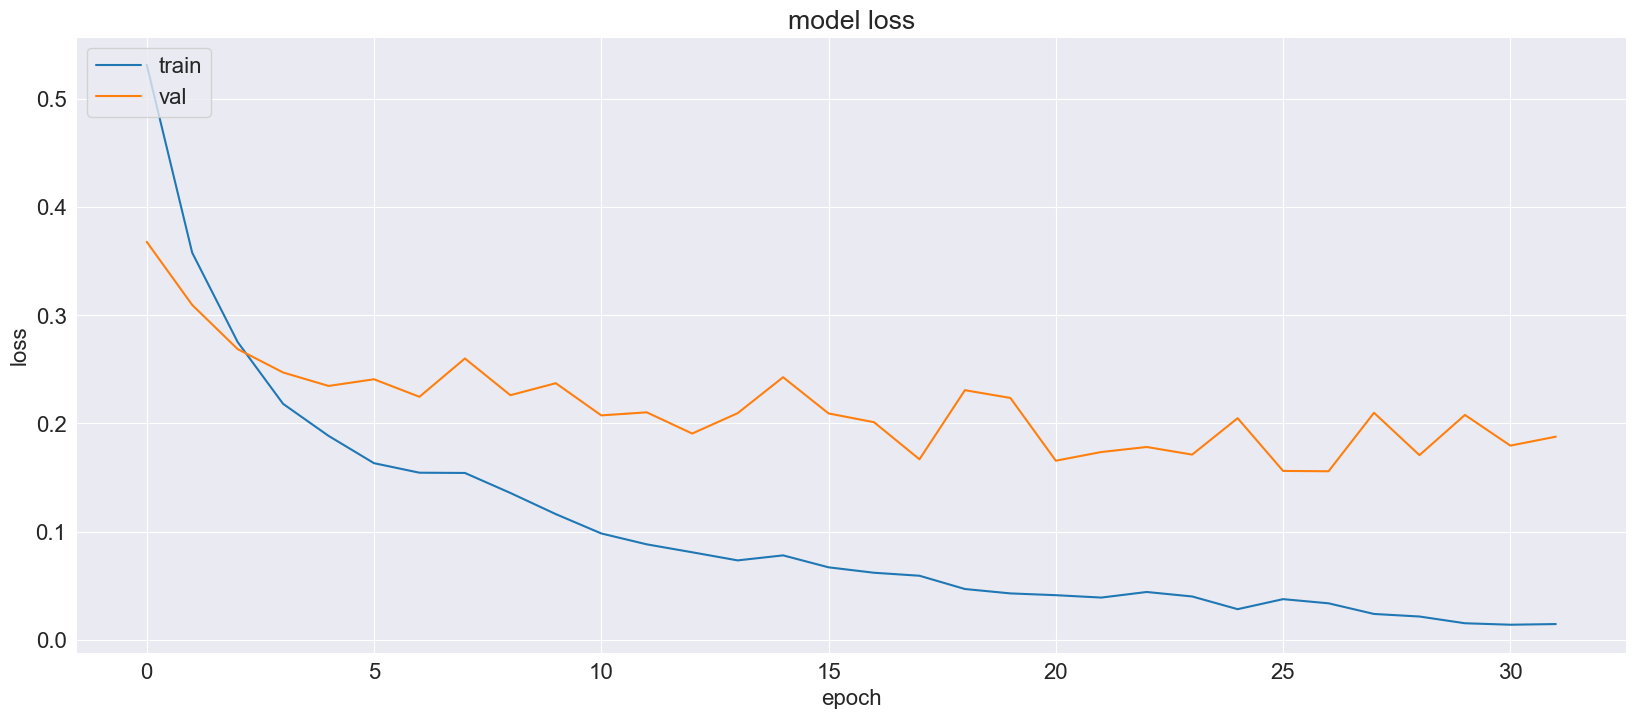

In [313]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

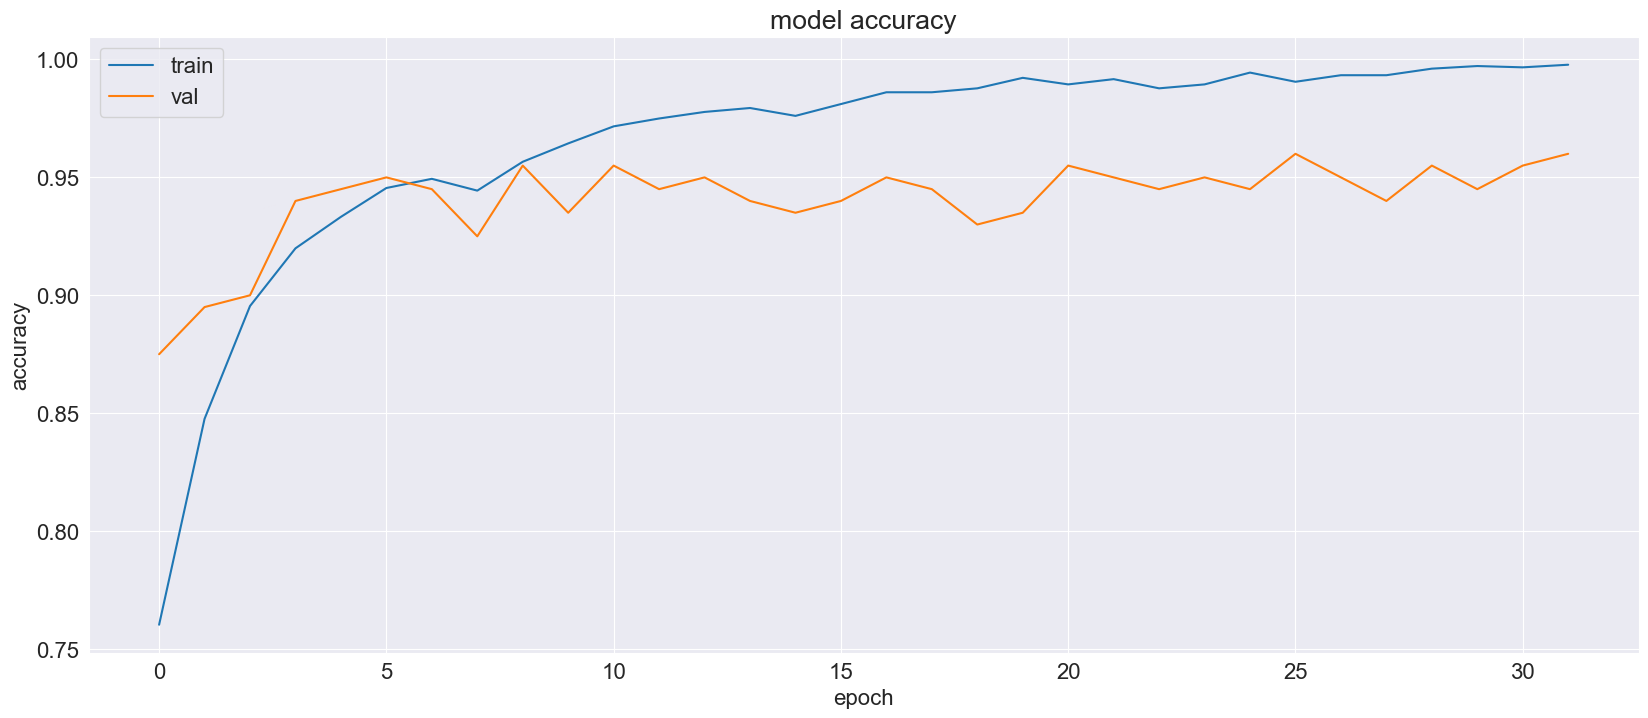

In [314]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


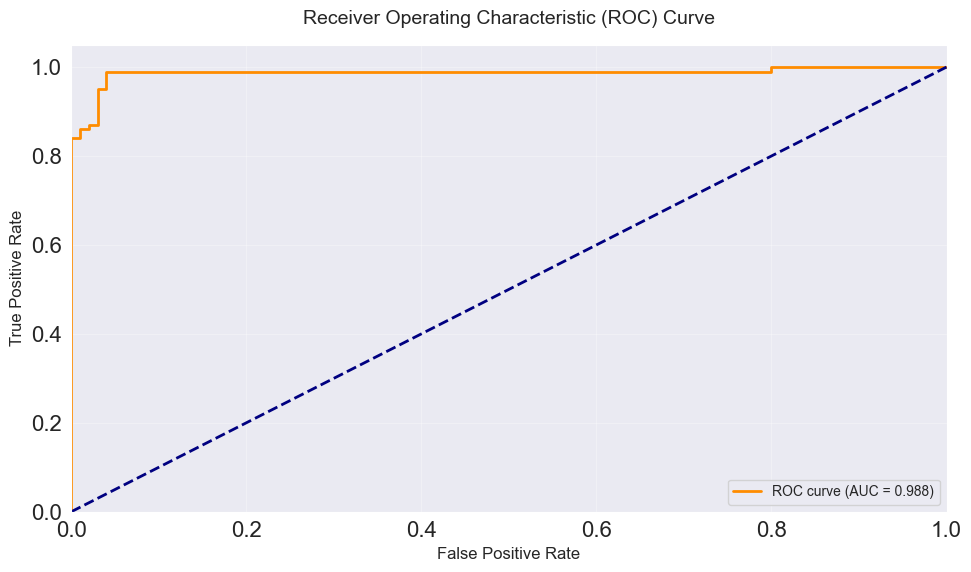

In [236]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

y_pred_proba = model.predict(X_test_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, pad=15)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

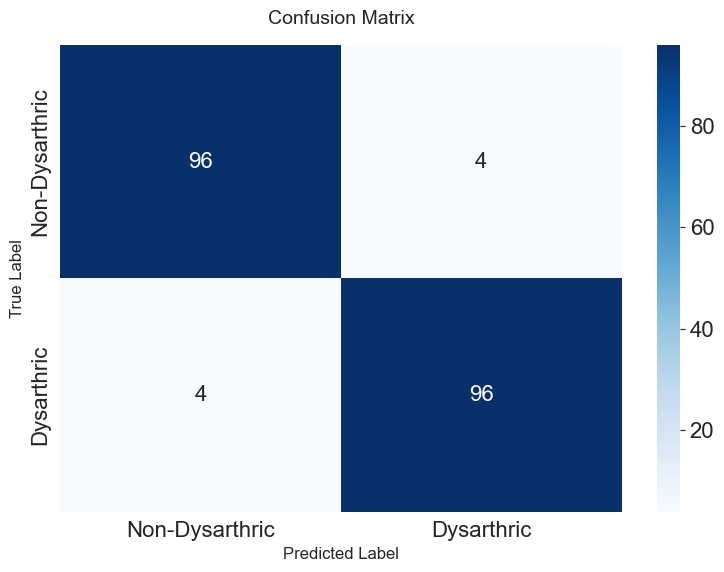

In [315]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Dysarthric', 'Dysarthric'],
            yticklabels=['Non-Dysarthric', 'Dysarthric'])
plt.title('Confusion Matrix', fontsize=14, pad=15)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [332]:
from sklearn.metrics import classification_report

# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Non-Dysarthric', 'Dysarthric']))

print(roc_auc_score(y_test, y_pred_proba))


Classification Report:
                precision    recall  f1-score   support

Non-Dysarthric       0.96      0.96      0.96       100
    Dysarthric       0.96      0.96      0.96       100

      accuracy                           0.96       200
     macro avg       0.96      0.96      0.96       200
  weighted avg       0.96      0.96      0.96       200

0.9875999999999998


The classification of hypoxia-induced slurring in pilot's speech using MFCCs and Convolutional Neural Networks has demonstrated excellent performance, achieving 95% accuracy, precision, and recall across both dysarthric and non-dysarthric classes, with an AUC of 0.9941. The model shows consistent performance across all metrics, suggesting robust and reliable classification capabilities for both normal and impaired speech patterns. The balanced performance across both classes (shown by identical precision and recall values of 0.95) indicates the model is equally effective at identifying both dysarthric and non-dysarthric speech, making it a potentially valuable tool for monitoring pilot speech patterns.

The classification of hypoxia-induced slurring in pilot's speech using MFCCs and Convolutional Neural Networks has demonstrated high effectiveness, achieving an accuracy of 95% and an AUC of 0.9906, indicating strong predictive performance and reliability in distinguishing dysarthric speech patterns.

### Running the model on some interesting real world pilot hypoxia incidents

In [322]:
scaler = StandardScaler()

features_list = []
for _, row in data.iloc[:100].iterrows():  
    y, sr = librosa.load(row['filename'])
    noise_clip = y[0:int(sr)]
    reduced = nr.reduce_noise(
        y=y, 
        sr=sr,
        y_noise=noise_clip,
        prop_decrease=1,
        freq_mask_smooth_hz=500,
        n_std_thresh_stationary=2
    )
    features = extract_features(reduced, sr)
    features_list.append(features)

scaler.fit(np.array(features_list))

def predict_dysarthria(y, sr, scaler):
    noise_clip = y[0:int(sr)]
    reduced = nr.reduce_noise(
        y=y, 
        sr=sr,
        y_noise=noise_clip,
        prop_decrease=1,
        freq_mask_smooth_hz=500,
        n_std_thresh_stationary=2
    )
    
    features = extract_features(reduced, sr)
    
    features_scaled = scaler.transform(features.reshape(1, -1))
    
    n_rows = int(np.ceil(np.sqrt(136)))
    n_cols = int(np.ceil(136 / n_rows))
    X_padded = np.zeros((1, n_rows * n_cols))
    X_padded[:, :136] = features_scaled
    X_reshaped = X_padded.reshape(-1, n_rows, n_cols, 1)
    
    pred = model.predict(X_reshaped, verbose=0)
    return pred[0][0]

#### 2021 Cessna Conquest incident in Indiana

<img src="./images/indiana_atc.png" style="max-height: 500px;"/>
<img src="./images/declare.png" style="max-height: 500px;"/>

In [403]:
y, sr = librosa.load("./samples/N441LS_hypoxia.wav")
print("\nHypoxia sample prediction:", predict_dysarthria(y, sr, scaler))


Hypoxia sample prediction: 0.97344445


In [404]:
ipd.Audio(y, rate=sr)

### Kalitta 66 Incident
<img src="./images/kalitta_66.png" style="max-height: 500px;"/>
<img src="./images/kalitta.png" style="max-height: 500px;"/>


Hypoxia sample prediction: 0.98546662


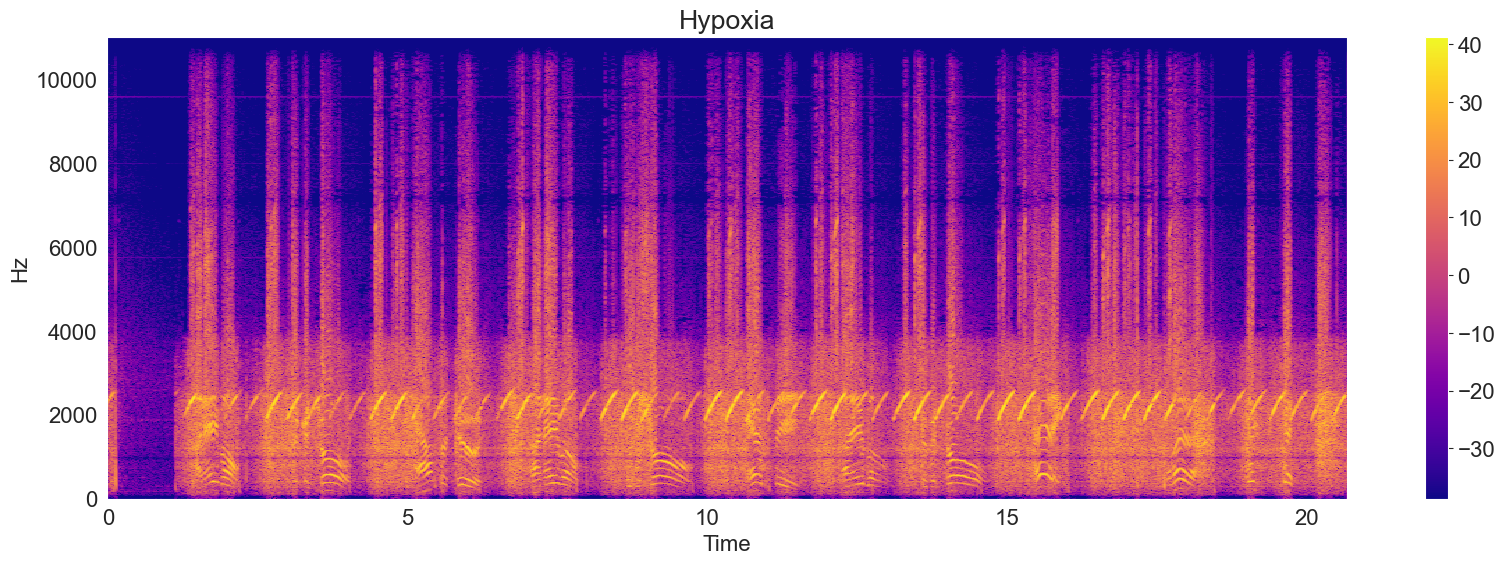

In [ ]:
y, sr = librosa.load("./samples/Kalitta66_hypoxia.wav")
print("\nHypoxia sample prediction:", predict_dysarthria(y, sr, scaler))

show_spectrogram(y, sr, "Hypoxia")
ipd.Audio(y, rate=sr)

#### Control against the (non-hypoxic) Air Traffic Controller speaking to Kalitta 66


Hypoxia sample prediction: 0.08443516


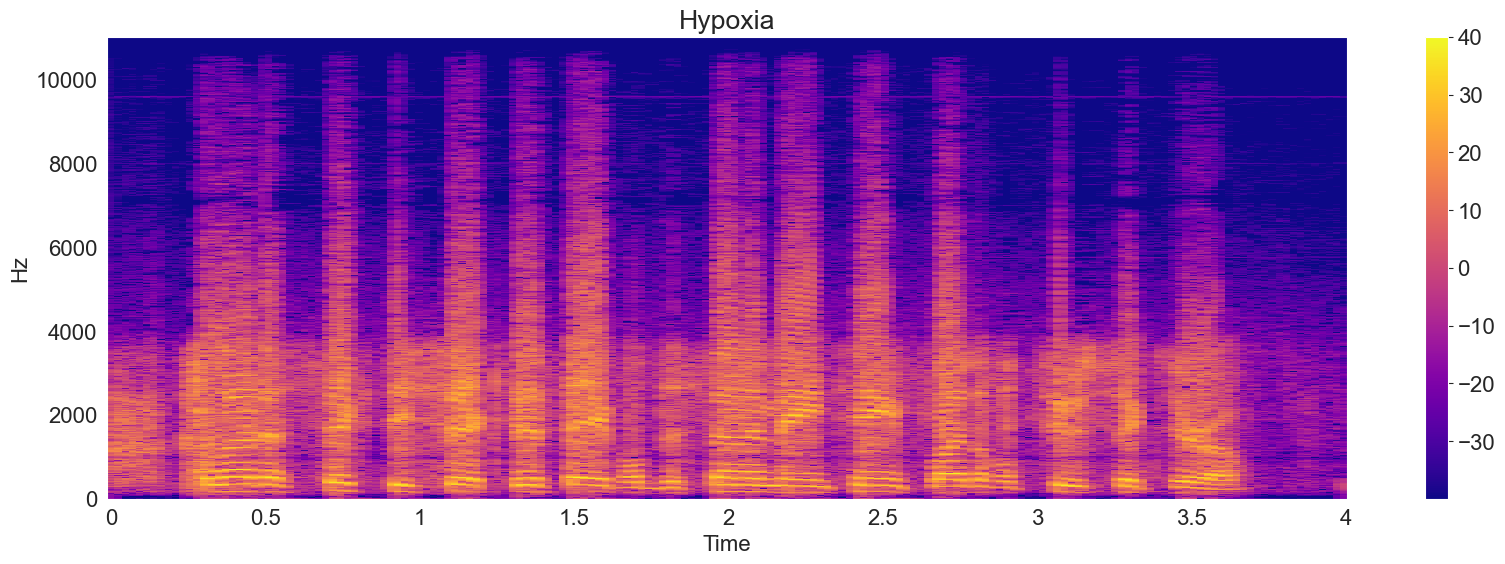

In [330]:
y, sr = librosa.load("./samples/Kalitta66.wav")
print("\nHypoxia sample prediction:", predict_dysarthria(y, sr, scaler))

show_spectrogram(y, sr, "Hypoxia")
ipd.Audio(y, rate=sr)